In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq
from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 45
seed = 10
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()

test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a_train)
adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [3]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [4]:
params = {"epsilon": 1e-2, "alpha": 1e-3}
epsilon, alpha = params["epsilon"], params["alpha"]

In [5]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "spatial"},
    var_names=adata_sp_train.var_names.values,
    callback="local-pca" if adata_sp_train.shape[1] > 100 else None,
    kwargs={"joint-space": True},
)

In [6]:
print(
    prob.problems[("src", "tgt")].xy.data.shape,
    prob.problems[("src", "tgt")].xy.data_y.shape,
)

(1089, 30) (1088, 30)


In [7]:
params = {"epsilon": 1e-2, "alpha": 0.5}
epsilon, alpha = params["epsilon"], params["alpha"]

In [8]:
prob = prob.solve(
    alpha=alpha,
    epsilon=epsilon,
    max_iterations=10_000,  # tau_a=1.0, tau_b=0.8
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

2022-10-12 12:16:57.052609: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-12 12:16:57.222648: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-12 12:16:57.426695: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is kn

True
1.1189667487193231


In [9]:
adata_pred = prob.impute(var_names=true_df.columns.tolist(), device="cpu")
pred_df = sc.get.obs_df(adata_pred, keys=true_df.columns.tolist())

2022-10-12 12:17:54.345663: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-12 12:17:55.601728: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [10]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [11]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [12]:
out.max(0)

pearson     0.110358
spearman    0.081105
dtype: float64

In [13]:
out.mean(0)

pearson     0.002709
spearman    0.007966
dtype: float64

In [14]:
out

,pearson,spearman
D630039A03Rik,-0.022230,-0.000945
Esyt2,-0.051139,-0.033916
Gm14236,-0.003197,0.056718
Tspo,0.009585,0.030961
Tceal1,-0.002739,-0.015305
...,...,...
9430015G10Rik,0.008878,0.000602
D030056L22Rik,-0.024713,0.034567
Smim18,-0.005386,-0.017006
Fbxl19,-0.011656,-0.015321


In [15]:
adata_pred.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

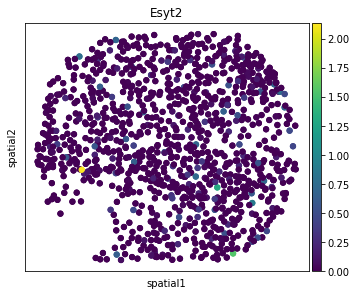

In [17]:
sq.pl.spatial_scatter(adata_pred, color=["Esyt2"], shape=None)

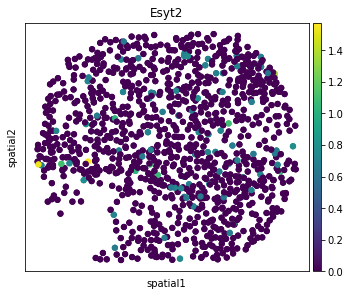

In [19]:
sq.pl.spatial_scatter(adata_sp_b, color=["Esyt2"], shape=None)